In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import glob
import re
import pandas as pd
import seaborn as sns
import math
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from scipy.stats import ttest_ind
from io import StringIO
import os
import torch

RDKit WARNING: [13:39:05] Enabling RDKit 2020.03.1dev1 jupyter extensions


# Helper functions to be used throughout the analysis

In [3]:
def get_stats(pred, gold):
    rmse=np.sqrt(np.mean((pred-gold)**2))
    r2=np.corrcoef(pred,gold)[0][1]**2
    return(rmse,r2)

In [4]:
plt.rc('axes',labelsize=13)
plt.rc('axes',titlesize=13)

## Generating LaTeX for Table 1 and STable1

In [4]:
data=pd.read_csv('data/soltrannet_sweep_table.csv')

In [5]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' in x]))

\begin{tabular}{llrrrrrr}
\toprule
{} &    Model &  Parameters &  CCV RMSE &  Fold0 RMSE &  Fold1 RMSE &  Fold2 RMSE &  Ind RMSE \\
\midrule
0  &      MAT &    42049537 &     2.007 &       1.231 &       3.075 &       1.058 &     2.113 \\
1  &        0 &    21061633 &     1.449 &       1.161 &       1.959 &       1.054 &     1.914 \\
2  &        1 &      502529 &     1.467 &       1.231 &       1.972 &       1.028 &     1.946 \\
3  &        2 &      336385 &     1.377 &       1.260 &       1.682 &       1.126 &     1.870 \\
4  &        3 &      336385 &     1.454 &       1.239 &       1.857 &       1.165 &     1.949 \\
5  &        4 &       22657 &     1.297 &       1.187 &       1.582 &       1.066 &     1.903 \\
6  &        5 &       11905 &     1.271 &       1.130 &       1.605 &       0.998 &     1.923 \\
7  &        6 &       11905 &     1.350 &       1.272 &       1.680 &       1.012 &     1.903 \\
8  &        7 &        3393 &     1.459 &       1.172 &       1.916 &       1.159 &

In [6]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' not in x]))

\begin{tabular}{llrlrrrrrr}
\toprule
{} &    Model &  Parameters &    Model &  Parameters &  CCV \$R\textasciicircum 2\$ &  Fold0 \$R\textasciicircum 2\$ &  Fold1 \$R\textasciicircum 2\$ &  Fold2 \$R\textasciicircum 2\$ &  Ind \$R\textasciicircum 2\$ \\
\midrule
0  &      MAT &    42049537 &      MAT &    42049537 &     0.5320 &       0.7510 &       0.3320 &       0.7150 &     0.3750 \\
1  &        0 &    21061633 &        0 &    21061633 &     0.6700 &       0.7780 &       0.5200 &       0.7270 &     0.4718 \\
2  &        1 &      502529 &        1 &      502529 &     0.6620 &       0.7690 &       0.4650 &       0.7330 &     0.4576 \\
3  &        2 &      336385 &        2 &      336385 &     0.6930 &       0.7640 &       0.5630 &       0.7060 &     0.4890 \\
4  &        3 &      336385 &        3 &      336385 &     0.6720 &       0.7640 &       0.5390 &       0.6850 &     0.4461 \\
5  &        4 &       22657 &        4 &       22657 &     0.7240 &       0.7800 &       0.6260 &     

## Generating the data for Table 2 and SFigXX

In [7]:
#step 1 -- Generating the dictionary for the things
data={}
for dyn in range(1,21):
    data[dyn]={'R2':[],'RMSE':[],'ensR2':0,'ensRMSE':0}
    predfiles=glob.glob(f'data/predictions/final_model_ind_dyn{dyn}_*.predictions')
    
    preds=[]
    
    for f in predfiles:
        tmp=pd.read_csv(f)
        preds.append(tmp['pred'].to_list())
        g=np.array(tmp['true'].to_list())
        p=np.array(tmp['pred'].to_list())
        ccvRMSE,ccvR2=get_stats(g,p)
        data[dyn]['R2'].append(ccvR2)
        data[dyn]['RMSE'].append(ccvRMSE)
    
    ensemble_preds=np.array([np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*preds)])
    ensRMSE,ensR2=get_stats(g,ensemble_preds)
    data[dyn]['ensR2']=ensR2
    data[dyn]['ensRMSE']=ensRMSE

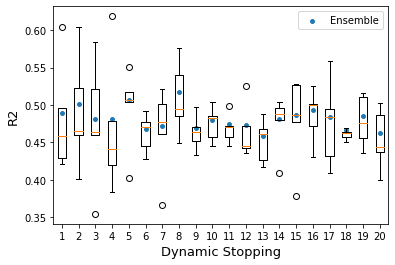

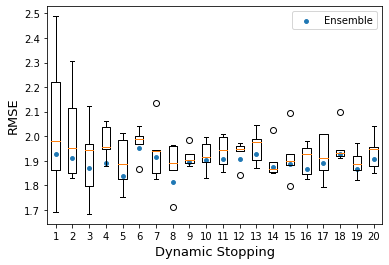

In [8]:
#step 2 -- Generating the Supplemental Figure
for thing in ['R2','RMSE']:
    xs=list(range(1,21))
    toplot=[]
    for x in xs:
        toplot.append(data[x][thing])
    
    counter=1
    xs2=[]
    for item in toplot:
        xs2.append([counter,counter,counter,counter,counter])
        counter+=1
    
    ens_toplot=[]
    for x in xs:
        ens_toplot.append(data[x]['ens'+thing])
    
    fig=plt.figure()
    plt.boxplot(toplot)
    plt.scatter(xs,ens_toplot,s=15,label='Ensemble')
    #plt.scatter(xs2,toplot,s=10,label='Individual',color='green')
    plt.legend()
    plt.ylabel(thing)
    plt.xlabel('Dynamic Stopping')
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    plt.savefig(f'figures/final_model_ind_dyn_{thing}.pdf')

In [11]:
#determining the min Average RMSE
mRMSE=99999999
mdyn=0
for dyn in data:
    ave=np.mean(data[dyn]['RMSE'])
    if ave < mRMSE:
        mRMSE=ave
        mdyn=dyn
print(mRMSE,mdyn)

1.8778042721844361 8


In [12]:
#step 3 -- Generating the mean and standard deviation of the deployed model on the independent test set
predfiles=glob.glob("data/predictions/final_model_ind_dyn8_*.predictions")
bestRMSEmodel=""
bestR2model=""
bRMSE=99999
bR2=-1
rmses=[]
r2s=[]
for f in predfiles:
    tmp=pd.read_csv(f)
    preds.append(tmp['pred'].to_list())
    g=np.array(tmp['true'].to_list())
    p=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(g,p)
    rmses.append(ccvRMSE)
    r2s.append(ccvR2)
    if ccvRMSE < bRMSE:
        bRMSE=ccvRMSE
        bestRMSEmodel=f
    if ccvR2 > bR2:
        bR2=ccvR2
        bestR2model=f
print(bRMSE,bestRMSEmodel)
print(bR2,bestR2model)

1.710710001150879 data/predictions/final_model_ind_dyn8_s3.predictions
0.5768538649308053 data/predictions/final_model_ind_dyn8_s3.predictions


In [13]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.8778042721844361 0.09250513883450179
0.5091304692377083 0.04449225019642136


In [14]:
data[8]

{'R2': [0.48587103661398673,
  0.5395078064304927,
  0.494589388378514,
  0.5768538649308053,
  0.4488302498347425],
 'RMSE': [1.8618233762985488,
  1.9648817263389258,
  1.8910191117034012,
  1.710710001150879,
  1.9605871454304256],
 'ensR2': 0.5174486206148375,
 'ensRMSE': 1.8137960146982184}

In [17]:
#step 4 -- Generating the data for the training set
todo=glob.glob('data/training_data/final_model/*dyn8*testdic.pi')
rmses=[]
r2s=[]
for fname in todo:
    dic=pickle.load(open(fname,'rb'))
    rmses.append(dic['RMSE'])
    r2s.append(dic['R2'])
    if 'seed3' in fname:
        print(dic['RMSE'],dic['R2'])

1.14423482786716 0.7766111073887221


In [16]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.170649141893826 0.05043465715814216
0.7843932174479028 0.0064311381188713055


In [18]:
#step 5 -- Generating the data for the Ensemble on the Training set
todo=glob.glob('data/training_data/final_model/ind*.predictions')
preds=[]
    
for f in todo:
    tmp=pd.read_csv(f)
    preds.append(tmp['pred'].to_list())
    g=np.array(tmp['true'].to_list())
    p=np.array(tmp['pred'].to_list())
    #ccvRMSE,ccvR2=get_stats(g,p)
    #data[dyn]['R2'].append(ccvR2)
    #data[dyn]['RMSE'].append(ccvRMSE)

ensemble_preds=np.array([np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*preds)])
ensRMSE,ensR2=get_stats(g,ensemble_preds)
print(ensRMSE,ensR2)

1.0676152969384596 0.7983174792699118


## Generating the figures for 2D vs 3D embeddings of the molecule

In [17]:
# need 2D vs 3D plots & t-test for significance for the first 10 models.
def plotter(xlabel,ylabel,hue,dataframe,savename):
    fig=plt.figure()
    sns.boxplot(xlabel,ylabel,data=dataframe,color='w')
    a=sns.swarmplot(xlabel,ylabel,hue=hue,data=df)
    plt.legend(bbox_to_anchor=(1.05,1),loc=2)
    plt.tight_layout()
    plt.savefig(savename)

In [20]:
df=pd.read_csv('data/model_selection.csv')

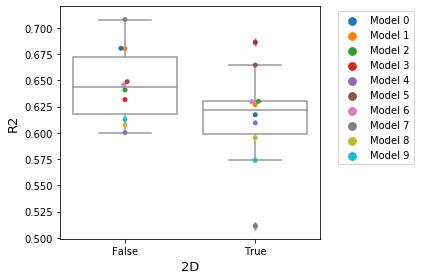

In [21]:
plotter('2D','R2','model',df,'figures/2dv3d_r2.pdf')

In [22]:
#T-Test for the above plot
ttest_ind(df[df['2D']==True]['R2'],df[df['2D']==False]['R2'])

Ttest_indResult(statistic=-1.6514130654734087, pvalue=0.11599231168237253)

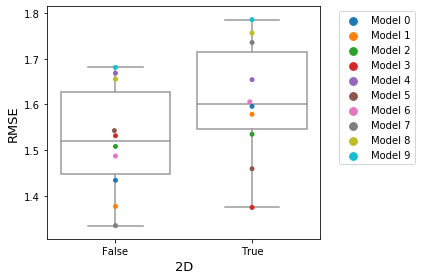

In [23]:
plotter('2D','RMSE','model',df,'figures/2dv3d_rmse.pdf')

In [24]:
#T-Test for the above plot
ttest_ind(df[df['2D']==True]['RMSE'],df[df['2D']==False]['RMSE'])

Ttest_indResult(statistic=1.528668871470288, pvalue=0.14372944251741623)

## Generating the figures for Fragmenting Salt analysis

In [25]:
basedirs=['final_model_full_saltfragafter','final_model_noothers_saltfragafter','final_model_others2plus_saltfragafter','final_model_othersMW_saltfragafter']
saltfrag_data={}
for d in basedirs:
    saltfrag_data[d]={}
    for thing in ['train_test','trainsalt_test','train_testsalt','trainsalt_testsalt']:
        saltfrag_data[d][thing]={'RMSEs':[],'R2s':[]}
        for seed in ['0','1','2','3','4']:
            preds=np.array([])
            golds=np.array([])

            #we are working with full ccv for training to predict the removed test set
            predfiles=glob.glob(f'data/predictions/{d}/*{thing}_s{seed}f*.predictions')
            for f in predfiles:
                tmp=pd.read_csv(f)
                g=np.array(tmp['true'].to_list())
                p=np.array(tmp['pred'].to_list())
                golds=np.append(golds,g)
                preds=np.append(preds,p)
            #now that we have the full preds and golds arrays we can calculate the R2 and RMSE
            ccvRMSE,ccvR2=get_stats(preds,golds)
            saltfrag_data[d][thing]['RMSEs'].append(ccvRMSE)
            saltfrag_data[d][thing]['R2s'].append(ccvR2) 

Full Aqsol Data R2s Ttest_indResult(statistic=2.1934859709055674, pvalue=0.059596186794829656)
Full Aqsol Data R2s Ttest_indResult(statistic=-1.4496020124670712, pvalue=0.1852121098547752)
Full Aqsol Data RMSEs Ttest_indResult(statistic=0.39843371673204203, pvalue=0.7007329710106283)
Full Aqsol Data RMSEs Ttest_indResult(statistic=1.0367278229758814, pvalue=0.3301805727392053)
Aqsol Without Other typed molecules R2s Ttest_indResult(statistic=1.5682761197747412, pvalue=0.15545399812278501)
Aqsol Without Other typed molecules R2s Ttest_indResult(statistic=-3.2559355988055563, pvalue=0.011597594438226016)
Aqsol Without Other typed molecules RMSEs Ttest_indResult(statistic=-0.945887667575338, pvalue=0.371895084315655)
Aqsol Without Other typed molecules RMSEs Ttest_indResult(statistic=1.9676839728315874, pvalue=0.08464632784846401)
Aqsol Without 1 atom Other typed molecules R2s Ttest_indResult(statistic=2.7779296914994833, pvalue=0.02400111699633856)
Aqsol Without 1 atom Other typed molecu

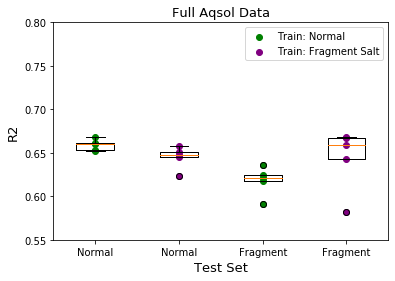

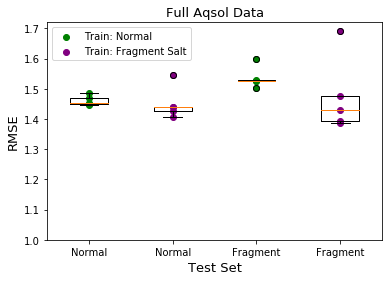

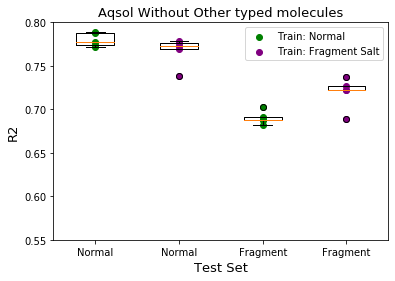

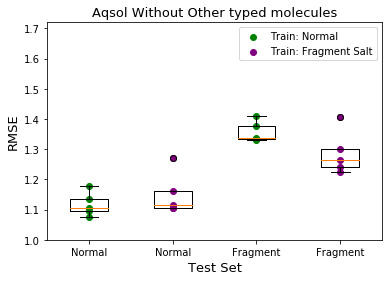

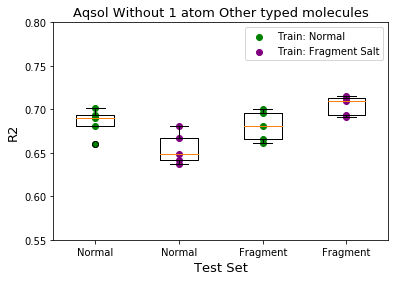

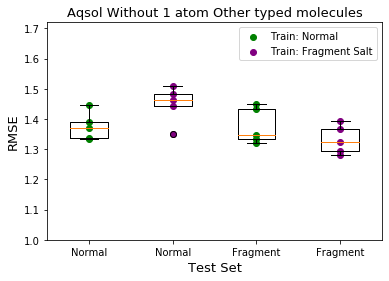

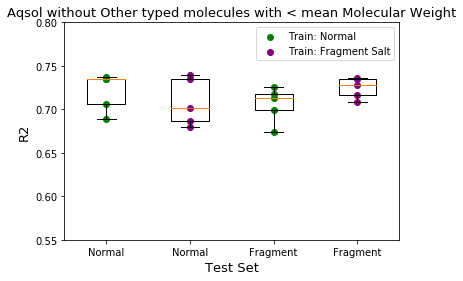

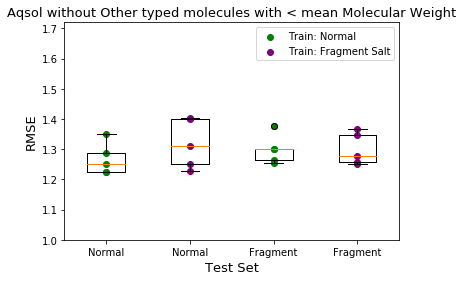

In [27]:
lookup_titles={
    'final_model_full_saltfragafter':'Full Aqsol Data',
    'final_model_noothers_saltfragafter':'Aqsol Without Other typed molecules',
    'final_model_others2plus_saltfragafter':'Aqsol Without 1 atom Other typed molecules',
    'final_model_othersMW_saltfragafter':'Aqsol without Other typed molecules with < mean Molecular Weight'
}

color_lookup={0:'purple',1:'green'}
label_lookup={
    0:'Train: Fragment Salt',
    1:'Train: Normal',
}
for d in basedirs:
    for thing in ['R2s','RMSEs']:
        fig,ax=plt.subplots()
        toplot=[]
        labels=['train_test','trainSF_test','train_testSF','trainSF_testSF']
        for x in labels:
            toplot.append(saltfrag_data[d][x.replace('SF','salt')][thing])
        ax.boxplot(toplot)
        
        x=1
        for item in [[toplot[0],toplot[2]],[toplot[1],toplot[3]]]:
            ax.scatter([[x,x,x,x,x],[x+2,x+2,x+2,x+2,x+2]],item,label=label_lookup[x%2],color=color_lookup[x%2])
            x+=1
        #plt.scatter([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4]],toplot,label=['Train: Salts','Train: Fragmented Salt','Train: Salts','Train: Fragmented Salt'],color=plot_colors)
        plt.xticks([1,2,3,4],['Normal','Normal','Fragment','Fragment'])
        plt.title(lookup_titles[d])
        if thing=='RMSEs':
            plt.ylim((1.0,1.72))
        else:
            plt.ylim((0.55,0.80))
        plt.ylabel(thing.replace('s',''))
        plt.legend()
        plt.xlabel('Test Set')
        plt.savefig(f'figures/{d.split("_")[-2]}_saltfragfirst_{thing}_boxplots.pdf')
        
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[0],toplot[1])}')
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[2],toplot[3])}')

## Generating the timing analysis here

In [3]:
os.chdir('src')
from data_utils import load_data_from_df as load_df_gpu
from data_utils import construct_loader as construct_loader_gpu
from data_utils import load_data_from_smiles as load_smiles_gpu

from cpu_data_utils import load_data_from_df as load_df_cpu
from cpu_data_utils import construct_loader as construct_loader_cpu
from cpu_data_utils import load_data_from_smiles as load_smiles_cpu

from transformer import make_model
import time

In [4]:
def complex_measure(model,list_of_smiles,two_d=False,model_cpu=False,batch_size=1):
    '''
    A more complicated measure of the forward-pass.
    
    This function takes in a list of smile strings, then will create the needed molecular graphs & run the forward-pass
    
    Assumes the model is in evaluate mode
    '''
    t0=time.time()
    ls=[0.0 for x in list_of_smiles]
    t1=time.time()
    if model_cpu:
        X,y=load_smiles_cpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    else:
        X,y=load_smiles_gpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    tload=time.time()-t1
    if model_cpu:
        data_loader=construct_loader_cpu(X,y,batch_size)
    else:
        data_loader=construct_loader_gpu(X,y,batch_size)
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    elapsed_fp=time.time()-t0
    return elapsed_fp,tload

In [5]:
#making the original MAT implementation -- GPU
d_atom=28
mat_model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

stn_model_params = {
    'd_atom': d_atom,
    'd_model': 8,
    'N': 8,
    'h': 2,
    'N_dense': 1,
    'lambda_attention': 0.5, 
    'lambda_distance': 0.0,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.1,
    'aggregation_type': 'mean'
}

In [7]:
mat_gpu=make_model(**mat_model_params)

mat_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [8]:
stn_gpu=make_model(**stn_model_params)
stn_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [7]:
smis=open('data/llinas2020/llinas2020_raw.csv').readlines()
smis=[x.split(',')[-1].rstrip() for x in smis[1:]]

In [10]:
for size in [1,8,16,32]:
    print('---------------',size,'-----------------')
    mgpu_2d=[]
    mgpu_3d=[]
    sgpu_2d=[]
    sgpu_3d=[]
    for run in range(10):
        mat_gpu_times_2d=[]
        mat_gpu_times_3d=[]
        stn_gpu_times_2d=[]
        stn_gpu_times_3d=[]
        mat_gpu_times_2d.append(complex_measure(mat_gpu,smis,two_d=True,batch_size=size))
        mat_gpu_times_3d.append(complex_measure(mat_gpu,smis,two_d=False,batch_size=size))
        stn_gpu_times_2d.append(complex_measure(stn_gpu,smis,two_d=True,batch_size=size))
        stn_gpu_times_3d.append(complex_measure(stn_gpu,smis,two_d=False,batch_size=size))
        #print(f'MAT GPU - 2D {np.mean([x[0] for x in mat_gpu_times_2d])} s per molecule')
        #print(f'MAT GPU - 3D {np.mean([x[0] for x in mat_gpu_times_3d])} s per molecule')
        #print(f'STN GPU - 2D {np.mean([x[0] for x in stn_gpu_times_2d])} s per molecule')
        #print(f'STN GPU - 3D {np.mean([x[0] for x in stn_gpu_times_3d])} s per molecule')
        #print('--------------------------------------------------------')
        mgpu_2d.append(np.mean([x[0] for x in mat_gpu_times_2d]))
        mgpu_3d.append(np.mean([x[0] for x in mat_gpu_times_3d]))
        sgpu_2d.append(np.mean([x[0] for x in stn_gpu_times_2d]))
        sgpu_3d.append(np.mean([x[0] for x in stn_gpu_times_3d]))
    print(f'MAT GPU - 2D {np.mean(mgpu_2d)/len(smis)}  {np.std(mgpu_2d)/len(smis)}')
    print(f'MAT GPU - 3D {np.mean(mgpu_3d)/len(smis)}  {np.std(mgpu_3d)/len(smis)}')
    print(f'STN GPU - 2D {np.mean(sgpu_2d)/len(smis)}  {np.std(sgpu_2d)/len(smis)}')
    print(f'STN GPU - 3D {np.mean(sgpu_3d)/len(smis)}  {np.std(sgpu_3d)/len(smis)}')

--------------- 1 -----------------
MAT GPU - 2D 0.020910159385565556  0.00030832033476966436
MAT GPU - 3D 0.13884264248790162  0.0038248946698265724
STN GPU - 2D 0.02199484146002567  0.00031752719909296023
STN GPU - 3D 0.14192226312377235  0.005537822891436434
--------------- 8 -----------------
MAT GPU - 2D 0.0048318494449962265  0.0003543686293546492
MAT GPU - 3D 0.12523224931774718  0.0032986482280083734
STN GPU - 2D 0.004895396304853035  0.00023923854260771195
STN GPU - 3D 0.12545353734132014  0.001528347107742225
--------------- 16 -----------------
MAT GPU - 2D 0.003719668316118645  6.983966525507799e-05
MAT GPU - 3D 0.12289811065702728  0.003187295036073775
STN GPU - 2D 0.0037382221583164097  0.00015345990743506627
STN GPU - 3D 0.1250505127690055  0.00523801892426219
--------------- 32 -----------------
MAT GPU - 2D 0.0034716143752589372  0.00015141242119326445
MAT GPU - 3D 0.1232871129657283  0.0019283516227051277
STN GPU - 2D 0.003267072547565807  7.521274938671213e-05
STN GP

In [15]:
for size in [64,128,132]:
    print('---------------',size,'-----------------')
    mgpu_2d=[]
    mgpu_3d=[]
    sgpu_2d=[]
    sgpu_3d=[]
    for run in range(10):
        mat_gpu_times_2d=[]
        mat_gpu_times_3d=[]
        stn_gpu_times_2d=[]
        stn_gpu_times_3d=[]
        mat_gpu_times_2d.append(complex_measure(mat_gpu,smis,two_d=True,batch_size=size))
        mat_gpu_times_3d.append(complex_measure(mat_gpu,smis,two_d=False,batch_size=size))
        stn_gpu_times_2d.append(complex_measure(stn_gpu,smis,two_d=True,batch_size=size))
        stn_gpu_times_3d.append(complex_measure(stn_gpu,smis,two_d=False,batch_size=size))
        #print(f'MAT GPU - 2D {np.mean([x[0] for x in mat_gpu_times_2d])} s per molecule')
        #print(f'MAT GPU - 3D {np.mean([x[0] for x in mat_gpu_times_3d])} s per molecule')
        #print(f'STN GPU - 2D {np.mean([x[0] for x in stn_gpu_times_2d])} s per molecule')
        #print(f'STN GPU - 3D {np.mean([x[0] for x in stn_gpu_times_3d])} s per molecule')
        #print('--------------------------------------------------------')
        mgpu_2d.append(np.mean([x[0] for x in mat_gpu_times_2d]))
        mgpu_3d.append(np.mean([x[0] for x in mat_gpu_times_3d]))
        sgpu_2d.append(np.mean([x[0] for x in stn_gpu_times_2d]))
        sgpu_3d.append(np.mean([x[0] for x in stn_gpu_times_3d]))
    print(f'MAT GPU - 2D {np.mean(mgpu_2d)/len(smis)}  {np.std(mgpu_2d)/len(smis)}')
    print(f'MAT GPU - 3D {np.mean(mgpu_3d)/len(smis)}  {np.std(mgpu_3d)/len(smis)}')
    print(f'STN GPU - 2D {np.mean(sgpu_2d)/len(smis)}  {np.std(sgpu_2d)/len(smis)}')
    print(f'STN GPU - 3D {np.mean(sgpu_3d)/len(smis)}  {np.std(sgpu_3d)/len(smis)}')

--------------- 64 -----------------
MAT GPU - 2D 0.003781374837412979  7.667755975936317e-05
MAT GPU - 3D 0.12608833403298347  0.0026142763404350833
STN GPU - 2D 0.003295805418130123  7.663593746725557e-05
STN GPU - 3D 0.12874670859539147  0.003282525612727194
--------------- 128 -----------------
MAT GPU - 2D 0.005054381760683927  0.0007070718912306037
MAT GPU - 3D 0.1282298631740339  0.0021120440978349276
STN GPU - 2D 0.0034029295950224908  0.0003279943043584604
STN GPU - 3D 0.12694866241830768  0.004398373802857859
--------------- 132 -----------------


RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 11.91 GiB total capacity; 9.84 GiB already allocated; 21.06 MiB free; 11.20 GiB reserved in total by PyTorch)

In [11]:
#doing the same analysis as above, but on CPU
mat_cpu=make_model(**mat_model_params)
mat_cpu.to('cpu')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [12]:
stn_cpu=make_model(**stn_model_params)
stn_cpu.to('cpu')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [13]:
for size in [1,8,16,32]:
    print('---------------',size,'-----------------')
    mcpu_2d=[]
    mcpu_3d=[]
    scpu_2d=[]
    scpu_3d=[]
    for run in range(10):
        mat_cpu_times_2d=[]
        mat_cpu_times_3d=[]
        stn_cpu_times_2d=[]
        stn_cpu_times_3d=[]
        mat_cpu_times_2d.append(complex_measure(mat_cpu,smis,two_d=True,model_cpu=True,batch_size=size))
        mat_cpu_times_3d.append(complex_measure(mat_cpu,smis,two_d=False,model_cpu=True,batch_size=size))
        stn_cpu_times_2d.append(complex_measure(stn_cpu,smis,two_d=True,model_cpu=True,batch_size=size))
        stn_cpu_times_3d.append(complex_measure(stn_cpu,smis,two_d=False,model_cpu=True,batch_size=size))
        #print(f'MAT CPU - 2D {np.mean([x[0] for x in mat_cpu_times_2d])} s per molecule')
        ##print(f'MAT CPU - 3D {np.mean([x[0] for x in mat_cpu_times_3d])} s per molecule')
        ##print(f'STN CPU - 2D {np.mean([x[0] for x in stn_cpu_times_2d])} s per molecule')
        ##print(f'STN CPU - 3D {np.mean([x[0] for x in stn_cpu_times_3d])} s per molecule')
        #print('--------------------------------------------------------')
        mcpu_2d.append(np.mean([x[0] for x in mat_cpu_times_2d]))
        mcpu_3d.append(np.mean([x[0] for x in mat_cpu_times_3d]))
        scpu_2d.append(np.mean([x[0] for x in stn_cpu_times_2d]))
        scpu_3d.append(np.mean([x[0] for x in stn_cpu_times_3d]))
    print(f'MAT CPU - 2D {np.mean(mcpu_2d)/len(smis)}  {np.std(mcpu_2d)/len(smis)}')
    print(f'MAT CPU - 3D {np.mean(mcpu_3d)/len(smis)}  {np.std(mcpu_3d)/len(smis)}')
    print(f'STN CPU - 2D {np.mean(scpu_2d)/len(smis)}  {np.std(scpu_2d)/len(smis)}')
    print(f'STN CPU - 3D {np.mean(scpu_3d)/len(smis)}  {np.std(scpu_3d)/len(smis)}')

--------------- 1 -----------------
MAT CPU - 2D 0.03903923576528376  0.0003020832141226742
MAT CPU - 3D 0.1620051443576813  0.003193723516009692
STN CPU - 2D 0.016256266471111412  0.0001582087915822247
STN CPU - 3D 0.1422702912128333  0.005017792236386928
--------------- 8 -----------------
MAT CPU - 2D 0.023325630209662697  0.0005021291629880309
MAT CPU - 3D 0.1462055038322102  0.0034461497233316163
STN CPU - 2D 0.004839391058141534  3.955233924581179e-05
STN CPU - 3D 0.1267715168721748  0.003910793691090573
--------------- 16 -----------------
MAT CPU - 2D 0.024680114153659706  0.0008173735074144251
MAT CPU - 3D 0.14795428677038713  0.0033025410907278996
STN CPU - 2D 0.004184706102718007  0.00010412711639246484
STN CPU - 3D 0.1253950227390636  0.0023872769593242696
--------------- 32 -----------------
MAT CPU - 2D 0.029678783452872073  0.0025155240247128827
MAT CPU - 3D 0.1493484554868756  0.0023153804768038535
STN CPU - 2D 0.004090028820615826  0.00011506552154023038
STN CPU - 3D 0

In [16]:
for size in [64,128,132]:
    print('---------------',size,'-----------------')
    mcpu_2d=[]
    mcpu_3d=[]
    scpu_2d=[]
    scpu_3d=[]
    for run in range(10):
        mat_cpu_times_2d=[]
        mat_cpu_times_3d=[]
        stn_cpu_times_2d=[]
        stn_cpu_times_3d=[]
        mat_cpu_times_2d.append(complex_measure(mat_cpu,smis,two_d=True,model_cpu=True,batch_size=size))
        mat_cpu_times_3d.append(complex_measure(mat_cpu,smis,two_d=False,model_cpu=True,batch_size=size))
        stn_cpu_times_2d.append(complex_measure(stn_cpu,smis,two_d=True,model_cpu=True,batch_size=size))
        stn_cpu_times_3d.append(complex_measure(stn_cpu,smis,two_d=False,model_cpu=True,batch_size=size))
        #print(f'MAT CPU - 2D {np.mean([x[0] for x in mat_cpu_times_2d])} s per molecule')
        ##print(f'MAT CPU - 3D {np.mean([x[0] for x in mat_cpu_times_3d])} s per molecule')
        ##print(f'STN CPU - 2D {np.mean([x[0] for x in stn_cpu_times_2d])} s per molecule')
        ##print(f'STN CPU - 3D {np.mean([x[0] for x in stn_cpu_times_3d])} s per molecule')
        #print('--------------------------------------------------------')
        mcpu_2d.append(np.mean([x[0] for x in mat_cpu_times_2d]))
        mcpu_3d.append(np.mean([x[0] for x in mat_cpu_times_3d]))
        scpu_2d.append(np.mean([x[0] for x in stn_cpu_times_2d]))
        scpu_3d.append(np.mean([x[0] for x in stn_cpu_times_3d]))
    print(f'MAT CPU - 2D {np.mean(mcpu_2d)/len(smis)}  {np.std(mcpu_2d)/len(smis)}')
    print(f'MAT CPU - 3D {np.mean(mcpu_3d)/len(smis)}  {np.std(mcpu_3d)/len(smis)}')
    print(f'STN CPU - 2D {np.mean(scpu_2d)/len(smis)}  {np.std(scpu_2d)/len(smis)}')
    print(f'STN CPU - 3D {np.mean(scpu_3d)/len(smis)}  {np.std(scpu_3d)/len(smis)}')

--------------- 64 -----------------
MAT CPU - 2D 0.033718981345494586  0.0021251558779537306
MAT CPU - 3D 0.1572213590145111  0.005434321249975611
STN CPU - 2D 0.004136947429541386  0.00029167654385339823
STN CPU - 3D 0.12759209762920032  0.003283018812053799
--------------- 128 -----------------
MAT CPU - 2D 0.04300167885693637  0.0020455410739308967
MAT CPU - 3D 0.1676779163606239  0.003638658883305786
STN CPU - 2D 0.004642645517985026  2.2606367303763895e-05
STN CPU - 3D 0.13062282078193896  0.005035386331926856
--------------- 132 -----------------
MAT CPU - 2D 0.04400759646386811  0.0006417047174314322
MAT CPU - 3D 0.16930726260849924  0.006186042968593536
STN CPU - 2D 0.004594645175066862  2.7935421819120038e-05
STN CPU - 3D 0.12658021034616412  0.002309496474131439


In [3]:
#doing the analysis as above but with the deployed verion.. (this is where I will determine GPU sizing things)
os.chdir('/home/paf46/git/SolTranNet')

from data_utils import load_data_from_df as ldfd_dep
from data_utils import construct_loader as cl_dep
from data_utils import load_data_from_smiles as ldfs_dep

from transformer import make_model as make_dep_model
import time

In [4]:
help(ldfs_dep)

Help on function load_data_from_smiles in module data_utils:

load_data_from_smiles(x_smiles, labels, add_dummy_node=True, one_hot_formal_charge=False)
    Load and featurize data from lists of SMILES strings and labels.
    
    Args:
        x_smiles (list[str]): A list of SMILES strings.
        labels (list[float]): A list of the corresponding labels.
        add_dummy_node (bool): If True, a dummy node will be added to the molecular graph. Defaults to True.
        one_hot_formal_charge (bool): If True, formal charges on atoms are one-hot encoded. Defaults to False.
    
    Returns:
        A tuple (X, y) in which X is a list of graph descriptors (node features, adjacency matrices, distance matrices),
        and y is a list of the corresponding labels.



In [5]:
def complex_measure_dep(model,list_of_smiles,batch_size=1):
    '''
    A more complicated measure of the forward-pass.
    
    This function takes in a list of smile strings, then will create the needed molecular graphs & run the forward-pass
    
    Assumes the model is in evaluate mode
    '''
    t0=time.time()
    ls=[0.0 for x in list_of_smiles]
    t1=time.time()
    X,y=ldfs_dep(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True)
    tload=time.time()-t1
    
    data_loader=cl_dep(X,y,batch_size)
    
    for batch in data_loader:
        adjacency_matrix, node_features, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, None)
    elapsed_fp=time.time()-t0
    return elapsed_fp,tload

In [6]:
d_atom=28

stn_model_params = {
    'd_atom': d_atom,
    'd_model': 8,
    'N': 8,
    'h': 2,
    'N_dense': 1,
    'lambda_attention': 0.5, 
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'dropout': 0.1,
    'aggregation_type': 'mean'
}

stn_gpu=make_dep_model(**stn_model_params)
stn_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [7]:
smis=open('/home/paf46/git/SolTranNet_paper/data/llinas2020/test').readlines()
smis=[x.split(',')[-1].rstrip() for x in smis[1:]]

In [9]:
check=open('/home/paf46/git/SolTranNet_paper/data/llinas2020/llinas2020_raw.csv').readlines()
check=[x.split(',')[-1].rstrip() for x in check[1:]]

In [13]:
lens=[Chem.MolFromSmiles(x).GetNumAtoms() for x in check]

In [15]:
np.mean(lens),np.std(lens)

(24.78030303030303, 10.281134822649976)

In [16]:
np.max(lens)

85

In [10]:
for size in [1,8,16,32,64,128,132,150,200,250]:
    print('---------------',size,'-----------------')
    sgpu_2d=[]
    for run in range(10):
        stn_gpu_times_2d=[]
        stn_gpu_times_2d.append(complex_measure_dep(stn_gpu,smis,batch_size=size))
        #print(f'MAT GPU - 2D {np.mean([x[0] for x in mat_gpu_times_2d])} s per molecule')
        #print(f'MAT GPU - 3D {np.mean([x[0] for x in mat_gpu_times_3d])} s per molecule')
        #print(f'STN GPU - 2D {np.mean([x[0] for x in stn_gpu_times_2d])} s per molecule')
        #print(f'STN GPU - 3D {np.mean([x[0] for x in stn_gpu_times_3d])} s per molecule')
        #print('--------------------------------------------------------')
        
        sgpu_2d.append(np.mean([x[0] for x in stn_gpu_times_2d]))
    print(f'STN GPU - 2D {np.mean(sgpu_2d)/len(smis)}  {np.std(sgpu_2d)/len(smis)}')

--------------- 1 -----------------
STN GPU - 2D 0.019697758826342497  0.00034357475163407033
--------------- 8 -----------------
STN GPU - 2D 0.003641503597750808  5.768636009151298e-05
--------------- 16 -----------------
STN GPU - 2D 0.0026141531991236136  3.708577161277247e-05
--------------- 32 -----------------
STN GPU - 2D 0.002173944585251086  3.562266897237127e-05
--------------- 64 -----------------
STN GPU - 2D 0.0020654232664541767  5.541770007809233e-05
--------------- 128 -----------------
STN GPU - 2D 0.002027508345517245  7.184607699919947e-05
--------------- 132 -----------------
STN GPU - 2D 0.0021888701301632507  0.00019509197641584
--------------- 150 -----------------
STN GPU - 2D 0.002016978914087469  5.4961638565357456e-05
--------------- 200 -----------------
STN GPU - 2D 0.002074641305388826  8.118602320504802e-05
--------------- 250 -----------------
STN GPU - 2D 0.0021335562521761116  5.8624855402103866e-05


In [8]:
complex_measure_dep(stn_gpu,smis,batch_size=600)

(1.571798324584961, 0.7752296924591064)

In [ ]:
os.chdir('/home/paf46/git/SolTranNet_paper')

## Generating the Latex for the performance on multiple test sets

In [18]:
#calculating the means and standard deviations for the table
def helper(filename):
    tmp=pickle.load(open(filename,'rb'))
    return tmp['R2'],tmp['RMSE']

def helper2(filename):
    tmp=pd.read_csv(filename)
    gold=np.array(tmp['true'].to_list())
    pred=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(gold,pred)
    return ccvR2, ccvRMSE

#Cui et all 2020
todo=glob.glob('data/cui2020/*testdic.pi')
r2s=[]
rmses=[]
for fname in todo:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Cui2020 Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
print(f'Cui2020 Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print(f'Cui2020 Deployed: {helper2("data/cui2020/final_aq_model.predictions")}')
print('----------------------------------------')

#Boobier et al 2017
todo=glob.glob('data/boobier2017/*testdic.pi')

r2s=[]
rmses=[]
for fname in [x for x in todo if '_2d_' not in x]:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Boobier2017 R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
print(f'Boobier2017 Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print(f'Boobier2017 Deployed: {helper2("data/boobier2017/final_aq_model.predictions")}')
print('----------------------------------------')

#Louvric et al 2020
for key in ['seed*1000epochs','final_aq_model']:
    todo=glob.glob('data/louvric2020/'+key+'*.predictions')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper2(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'Louvric2020 Training {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
    print(f'Louvric2020 {key} Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
print('----------------------------------------')
#LLinas et al 2020
for key in ['llinas_set1','llinas_set2']:
    todo=glob.glob(f'data/llinas2020/soltrannet/{key}*testdic.pi')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'LLinas2020 {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')
    print(f'LLinas2020 {key} Training Best R2:{np.max(r2s)}   RMSE:{np.min(rmses)}')
    print(f'Llinas2020 {key} Deployed: {helper2(f"data/llinas2020/soltrannet/{key}_final_aq_model.predictions")}')

Cui2020 Training R2:0.5886204221886455,0.024413513767568156  RMSE:0.8600285893941907,0.21482372703860816
Cui2020 Best R2:0.6113130081035003   RMSE:0.6241022870681117
Cui2020 Deployed: (0.6563802388698684, 0.8127053399347246)
----------------------------------------
Boobier2017 R2:0.5432285946421288,0.1424843888425703  RMSE:1.2739101709030884,0.1775665240747097
Boobier2017 Best R2:0.7241077367030688   RMSE:1.010038294428349
Boobier2017 Deployed: (0.7728606218442503, 0.8453452132656011)
----------------------------------------
Louvric2020 Training seed*1000epochs Training R2:0.709438949167738,0.05365680996818616  RMSE:0.8979027406547612,0.10091079505030429
Louvric2020 seed*1000epochs Best R2:0.7830056219910293   RMSE:0.720145631344509
Louvric2020 Training final_aq_model Training R2:0.7443717125492011,0.03452115943712588  RMSE:0.853905298269586,0.06719889461724718
Louvric2020 final_aq_model Best R2:0.7942262979370159   RMSE:0.7334127415387698
----------------------------------------
LLina

In [11]:
def count_overlap(list_o_smiles):
    '''
    counts the number of identical molecules in list_o_smiles to AqSolDB
    '''
    
    aqsol_smiles=pd.read_csv('data/training_data/aqsol_2d.csv')['smiles'].tolist()
    aqsol_fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in aqsol_smiles]
    
    input_fps=[Chem.RDKFingerprint(Chem.MolFromSmiles(x)) for x in list_o_smiles]
    
    counter=0
    for fp1 in input_fps:
        for fp2 in aqsol_fps:
            if DataStructs.FingerprintSimilarity(fp1, fp2)==1:
                counter+=1
                break
    return counter

In [12]:
#Cui2020 overlap
cui_smis=pd.read_csv('data/cui2020/cui_et_all_sol_2d_testing.csv')['smiles'].tolist()
print(f'Cui Overlap: {count_overlap(cui_smis)}/{len(cui_smis)}')

RDKit WARNING: [15:37:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:37:03] WARNING: not r

Cui Overlap: 0/62


In [14]:
#boobier2017 overlap
boob_smis=pd.read_csv('data/boobier2017/dls100_test.csv')['smiles'].tolist()
print(f'Cui Overlap: {count_overlap(boob_smis)}/{len(boob_smis)}')

RDKit WARNING: [15:38:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:38:48] WARNING: not r

Cui Overlap: 23/25


In [16]:
#louvric2020 overlap
todo=glob.glob('data/louvric2020/louvric2020_*_test.csv')
overlaps=[]
for fname in todo:
    lov_smis=pd.read_csv(fname)['smiles'].tolist()
    overlaps.append(count_overlap(lov_smis))
    print(f'Cui Overlap: {count_overlap(lov_smis)}/{len(lov_smis)}')
print(np.mean(overlaps))

RDKit WARNING: [15:42:00] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:01] WARNING: not r

RDKit WARNING: [15:42:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:11] WARNING: not r

Cui Overlap: 155/166


RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:19] WARNING: not r

RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:29] WARNING: not r

Cui Overlap: 149/166


RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:36] WARNING: not r

RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:46] WARNING: not r

Cui Overlap: 148/166


RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:42:54] WARNING: not r

RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:03] WARNING: not r

Cui Overlap: 156/166


RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:11] WARNING: not r

RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:20] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:43:21] WARNING: not r

Cui Overlap: 149/166
151.4


In [17]:
#llinas2020 overlap
todo=glob.glob('data/llinas2020/llinas2020*test.csv')
for fname in todo:
    ll_smis=pd.read_csv(fname)['smiles'].tolist()
    print(f'llinas Overlap: {count_overlap(ll_smis)}/{len(ll_smis)}')

RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:08] WARNING: not r

llinas Overlap: 79/100


RDKit WARNING: [15:47:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:47:16] WARNING: not r

llinas Overlap: 18/32


In [19]:
data=pd.read_csv('data/soltrannet_othersets.csv')
data.columns

Index(['Dataset', 'Reported R2', 'Reported RMSE', 'SolTranNet Training R2',
       'SolTranNet Best R2', 'SolTranNet Deployed R2',
       'SolTranNet Training RMSE', 'SolTranNet Best RMSE',
       'SolTranNet Deployed RMSE', 'Deployed Training Overlap'],
      dtype='object')

In [20]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'RMSE' in x]+['Deployed Training Overlap']))

\begin{tabular}{llrlrll}
\toprule
{} &                 Dataset &  Reported RMSE & SolTranNet Training RMSE &  SolTranNet Best RMSE & SolTranNet Deployed RMSE & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &          0.681 &             0.860(0.215) &                 0.624 &                    0.813 &                      0/62 \\
1 &      Boobier et al 2017 &          0.985 &             1.274(0.178) &                 1.010 &                    0.845 &                     23/25 \\
2 &      Louvric et al 2020 &          0.720 &             0.898(0.101) &                 0.720 &            0.854(0.0672) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &          0.780 &             1.119(0.163) &                 0.952 &                    1.004 &                    79/100 \\
4 &  LLinas et al 2020 set2 &          1.060 &             1.811(0.328) &                 1.243 &                    1.295 &                     18/32 \\
\bottomrule
\end{tabular}



In [21]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'R2' in x]+['Deployed Training Overlap']))

\begin{tabular}{llllrll}
\toprule
{} &                 Dataset & Reported R2 & SolTranNet Training R2 &  SolTranNet Best R2 & SolTranNet Deployed R2 & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &       0.412 &          0.589(0.0244) &               0.611 &                  0.656 &                      0/62 \\
1 &      Boobier et al 2017 &       0.706 &           0.543(0.142) &               0.724 &                  0.773 &                     23/25 \\
2 &      Louvric et al 2020 &          -- &          0.709(0.0537) &               0.783 &          0.744(0.0345) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &        0.62 &          0.496(0.0268) &               0.527 &                  0.514 &                    79/100 \\
4 &  LLinas et al 2020 set2 &        0.75 &          0.769(0.0346) &               0.824 &                  0.726 &                     18/32 \\
\bottomrule
\end{tabular}



## Generating the plots for the "slicing analysis"?

In [22]:
def calc_stats(pred_array, true_array, insol_thresh=-6, lower_sol_thresh=-4, upper_sol_thresh=100000):
    '''
    This function will calculate the following on the predicted array:
        Hit% = #correct(lower_sol_thresh,upper_sol_thresh) / #(lower_sol_thresh,upper_sol_thresh)
        Fail% = #true(insol_thresh)pred(lower_sol_thresh,upper_sol_thresh) / #pred(lower_sol_thresh,upper_sol_thresh)
    
    Assumptions: pred_array,true_array are paired numpy arrays.
    '''
    
    #first we need to access the examples which have true in (lower_sol_thresh, upper_sol_thresh)
    true_mask=(true_array > lower_sol_thresh)&(true_array<upper_sol_thresh)
    
    #calculating the Hit%
    num_true=len(true_array[true_mask])
    poss_hits=pred_array[true_mask]
    num_hits=np.sum((poss_hits>lower_sol_thresh)&(poss_hits<upper_sol_thresh))
    hit=num_hits/float(num_true)
    
    #calculating the Fail%
    pred_mask=(pred_array > lower_sol_thresh)&(pred_array<upper_sol_thresh)
    insol_mask=true_array <= insol_thresh
    fail=np.sum(insol_mask & pred_mask) / float(np.sum(pred_mask))
    
    return hit,fail,np.sum(true_mask),np.sum(pred_mask)

In [23]:
data={'hit':[],'fail':[]}

#adding the SolTranNet data
truths=np.array([])
preds=np.array([])
for s in ['set1','set2']:
    tmp=pd.read_csv(f'data/llinas2020/soltrannet/llinas_{s}_final_aq_model.predictions')
    t=tmp['true']
    truths=np.append(truths,t)
    p=tmp['pred']
    preds=np.append(preds,p)
hit,fail,nt,npred=calc_stats(preds,truths)
data['hit'].append(('SolTranNet',hit))
data['fail'].append(('SolTranNet',fail))

In [24]:
data

{'hit': [('SolTranNet', 0.9482758620689655)],
 'fail': [('SolTranNet', 0.012987012987012988)]}

In [25]:
np.mean(truths)

-4.321439393939395

19


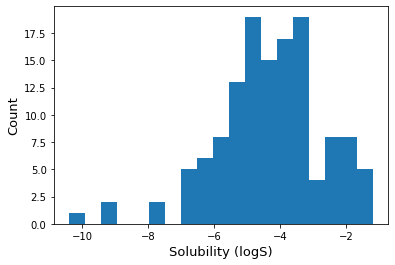

In [26]:
w=0.5
n=math.ceil((max(truths)-min(truths))/w)
print(n)
plt.hist(truths,bins=n)
plt.xlabel('Solubility (logS)')
plt.ylabel('Count')
plt.savefig('figures/histogram_solchal2_true_logs.pdf')

In [27]:
all_files=glob.glob('data/llinas2020/submitted/*.csv')
keys=set([x.split('/')[-1].split('_set')[0] for x in all_files])
for k in keys:
    truths=np.array([])
    preds=np.array([])
    todo=glob.glob(f'data/llinas2020/submitted/{k}*.csv')
    for fname in todo:
        tmp=pd.read_csv(fname)
        t=tmp['TRUE']
        truths=np.append(truths,t)
        p=tmp['PREDICTED']
        preds=np.append(preds,p)
    hit,fail,nt,npred=calc_stats(preds,truths)
    if np.isnan(hit):
        print(f'{k} hit is nan')
    else:
        data['hit'].append((k,hit))
    
    if np.isnan(fail):
        print(f'{k} fail is nan')
    else:
        data['fail'].append((k,fail))

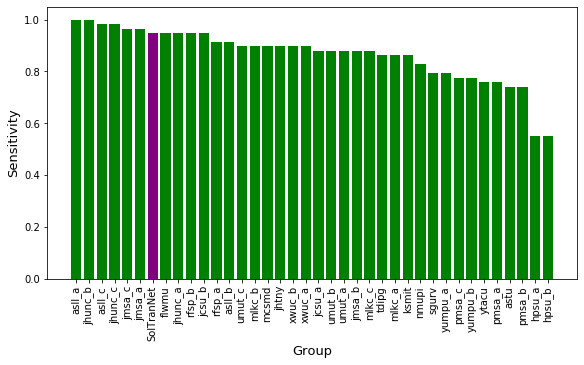

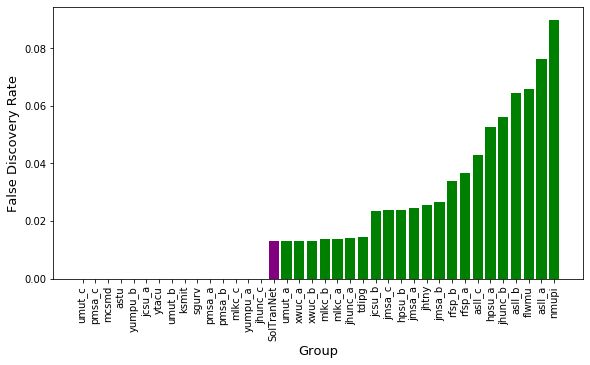

In [28]:
for k in data:
    fig=plt.figure(figsize=(9.5,5))
    if k=='hit':
        all_data=sorted(data[k],key=lambda x:x[1],reverse=True)
        plt.ylabel('Sensitivity')
    else:
        all_data=sorted(data[k],key=lambda x:x[1])
        plt.ylabel('False Discovery Rate')
    
    labels=[x[0] for x in all_data]
    ys=[x[1] for x in all_data]
    x_pos=[i for i,_ in enumerate(all_data)]
    colors=['purple' if x[0]=='SolTranNet' else 'green' for x in all_data]
    plt.bar(x_pos,ys,color=colors)
    plt.xlabel('Group')
    plt.xticks(x_pos,labels,rotation='vertical')
    plt.savefig(f'figures/{k}_solchal2.pdf')

## Making Supp Figs XXX

In [17]:
#Distribution of train/test solubilities for the scaffold split.
files=glob.glob('data/training_data/aqsol_scaf_2d_t*.csv')
sol_dic={'train':{},'test':{}}

for f in files:
    data=pd.read_csv(f)
    if '_train' in f:
        key1='train'
    else:
        key1='test'

    fold=f.split(key1)[-1][0]
    sol_dic[key1][fold]=data['y'].tolist()

61


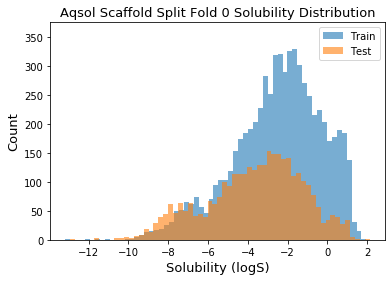

61


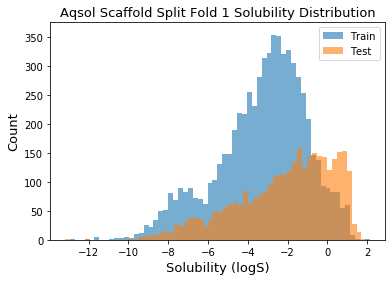

62


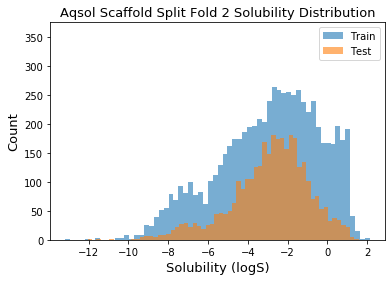

In [21]:
for fold in ['0','1','2']:
    w=0.25
    n=math.ceil((max(sol_dic['train'][fold])-min(sol_dic['train'][fold]))/w)
    print(n)
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    plt.figure()
    plt.hist(sol_dic['train'][fold],label='Train',alpha=0.6,bins=n)
    plt.hist(sol_dic['test'][fold],label='Test',alpha=0.6,bins=n)
    plt.ylabel('Count')
    plt.xlabel('Solubility (logS)')
    plt.title('Aqsol Scaffold Split Fold '+fold+' Solubility Distribution')
    plt.ylim((0,375))
    plt.legend()
    plt.savefig('figures/aqsol_scaf'+fold+'_soldist.pdf')
    plt.show()

62
47


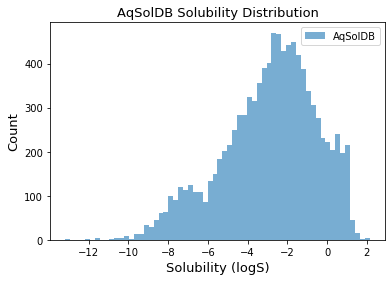

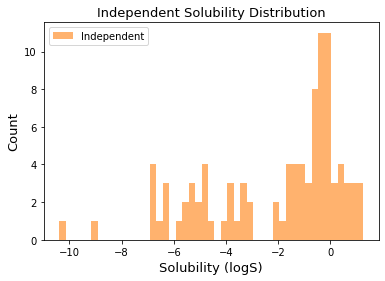

In [22]:
#doing the same for the full Aqsol set and our independent set
for fname in ['data/training_data/aqsol.csv','data/training_data/independent_sol.csv']:
    plt.figure()
    plt.rc('axes',labelsize=13)
    plt.rc('axes',titlesize=13)
    data=pd.read_csv(fname)
    if 'aqsol' in fname:
        l='AqSolDB'
        c='#1f77b4'
    else:
        l='Independent'
        c='#ff7f0e'
    w=0.25
    n=math.ceil((max(data['y'])-min(data['y']))/w)
    print(n)
    plt.hist(data['y'],label=l,color=c,alpha=0.6,bins=n)
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('Solubility (logS)')
    plt.title(f'{l} Solubility Distribution')
    plt.savefig(f'figures/{l}_solhist.pdf')